Урок 4.

Тема: ЗАДАЧА МАТРИЧНОЙ ФАКТОРИЗАЦИИ. АЛГОРИТМЫ ALS И BPR

Видео лекции: https://www.youtube.com/watch?v=_f_9TLBfTyA
        
Видео семинара: https://www.youtube.com/watch?v=MFlww6dpAUI

Ноутбук с практикой (этот):
https://disk.yandex.ru/d/jESLxdmQTtrhwA
Конспект notion:
https://www.notion.so/4-ALS-BPR-34a7a94ccc96499ea130eb5f4e471062
Конспект pdf:
https://disk.yandex.ru/i/ljttlTEkxzecNA
Презентация:
https://disk.yandex.ru/i/lP7Ni2cw1nV5Tg
        

In [1]:
# расскоментируйте код ниже, чтобы установить все зависимости
# !pip install -q \
#     pyarrow==12.0.1 \
#     polars==0.18.6 \
#     pandas==2.0.3 \
#     lightfm==1.17 \
#     optuna==3.3.0 \
#     tqdm==4.65.0 \
#     scipy==1.10.1 \
#     numpy==1.24.3 \
#     faiss-cpu==1.7.4 \
#     implicit==0.7.0

In [1]:
# раскоментируйте код ниже, чтобы скачать данные
# !wget -q https://files.grouplens.org/datasets/movielens/ml-1m.zip
# !unzip -q ml-1m.zip

In [3]:
import optuna
import random

import polars as pl
import pandas as pd
import numpy as np

from typing import List
import scipy.sparse as sp
from tqdm import tqdm
import matplotlib.pyplot as plt

import implicit
import faiss
from lightfm import LightFM

Как и раньше, будем работать с датаестом movielens, где есть информация об явной реакции для фильмов и сериалов

In [4]:
ratings = pd.read_csv(
    'ml-1m/ratings.dat', delimiter='::', header=None, 
    names=['user_id', 'item_id', 'rating', 'timestamp'], 
    engine='python'
)
ratings = pl.from_pandas(ratings).filter(pl.col('rating') >= 4)
ratings

user_id,item_id,rating,timestamp
i64,i64,i64,i64
1,1193,5,978300760
1,3408,4,978300275
1,2355,5,978824291
1,1287,5,978302039
1,2804,5,978300719
1,594,4,978302268
1,919,4,978301368
1,595,5,978824268
1,938,4,978301752


In [5]:
grouped_df = (
    ratings
    .groupby('user_id')
    .agg([
        pl.col('item_id').apply(lambda x: x[:-3]).alias('train_item_ids'),
        pl.col('rating').apply(lambda x: x[:-3]).alias('train_ratings'),
        pl.col('item_id').apply(lambda x: x[-3:]).alias('test_item_ids'),
        pl.col('rating').apply(lambda x: x[-3:]).alias('test_ratings'),
    ])
)
grouped_df

user_id,train_item_ids,train_ratings,test_item_ids,test_ratings
i64,list[i64],list[i64],list[i64],list[i64]
896,"[3797, 3798, … 3752]","[4, 5, … 4]","[3755, 2961, 3785]","[4, 5, 4]"
5856,"[589, 597, … 1036]","[5, 4, … 5]","[2000, 539, 2013]","[5, 4, 5]"
5312,"[3793, 2054, … 1090]","[4, 4, … 4]","[1097, 2040, 2042]","[5, 4, 4]"
1280,"[3798, 2997, … 2959]","[4, 4, … 4]","[2028, 553, 1089]","[5, 5, 5]"
3520,"[2987, 1249, … 1240]","[4, 4, … 4]","[3785, 1246, 1247]","[4, 5, 5]"
672,"[2987, 3930, … 3755]","[4, 4, … 4]","[1221, 2028, 3928]","[5, 5, 4]"
5664,"[589, 3000, … 1089]","[4, 5, … 5]","[1097, 2046, 2048]","[4, 5, 4]"
2432,"[589, 1262, … 1210]","[4, 4, … 5]","[1214, 541, 1240]","[4, 5, 4]"
1440,"[1263, 593, … 1233]","[4, 5, … 5]","[1234, 1240, 1242]","[4, 4, 4]"


In [6]:
median_seq_len = int(grouped_df['train_item_ids'].apply(len).median())
print(f"средняя длина сессии {median_seq_len}")

средняя длина сессии 55


In [7]:
# соберем строчки для разреженной матрицы
rows = []
cols = []
values = []

for user_id, train_item_ids, train_ratings in grouped_df.select(
    'user_id', 'train_item_ids', 'train_ratings'
).rows():
    rows.extend([user_id] * len(train_item_ids))
    cols.extend(train_item_ids)
    values.extend(train_ratings)

user_item_data = sp.csr_matrix((values, (rows, cols)), dtype=np.float32)
user_item_data

<6041x3953 sparse matrix of type '<class 'numpy.float32'>'
	with 557171 stored elements in Compressed Sparse Row format>

In [8]:
TOP_K = 10


def user_hitrate(y_relevant: List[str], y_recs: List[str], k: int = TOP_K) -> int:
    return int(len(set(y_relevant).intersection(y_recs[:k])) > 0)

In [9]:
RANDOM_STATE = 42

def set_seed():
    random.seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)
    
    
def get_recommendations(user_embs: np.array, item_embs: np.array, k: int = TOP_K):
    # строим индекс объектов
    index = faiss.IndexFlatIP(item_embs.shape[1])
    index.add(item_embs)

    # строим рекомендации с помощью dot-product расстояния
    return index.search(user_embs, k)

def evaluate_model(user_embs: np.array, item_embs: np.array):
    # строим рекомендации с запасом, так как включена фильтрация уже просмотренного
    # и может не остаться рекомендаций после нее
    _, recs = get_recommendations(user_embs, item_embs, TOP_K + median_seq_len)
    
    # посчитаем метрики качества рекомендаций
    hitrate_list = []
    for user_id, user_history, y_rel in grouped_df.select('user_id', 'train_item_ids', 'test_item_ids').rows():
        y_rec = [
            item_id
            for item_id in recs[user_id]
            # фильтруем уже просмотренное
            if item_id not in user_history
        ]
        hitrate_list.append(user_hitrate(y_rel, y_rec))
    return np.mean(hitrate_list)

## SVD

У такого алгоритма есть параметр `k` – количество главных компонент, которые можно интерпретировать как размерность скрытого пространства модели

Попробуем провести эксперимент с зависимостью от того, как хорошо алгоритм SVD восстанавливает матрицу рейтингов и качеством самих рекомендаций. Для этого будем использовать реализацию SVD алгоритма из библиотеки [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html)

100%|██████████| 20/20 [00:56<00:00,  2.82s/it]


Оптимальное k = 56 (Hitrate@10 = 0.234)


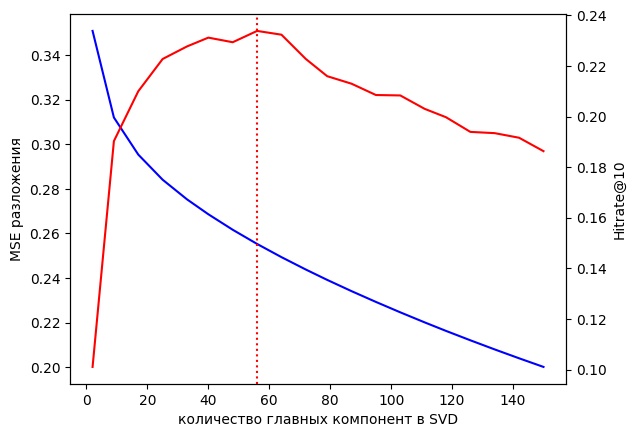

In [10]:
k_range = []
mse_list = []
mean_hitrate_list = []

for k in tqdm(np.linspace(2, 150, 20)):
    k = int(k)
    k_range.append(k)
    
    # выполним алгоритм SVD с заданным числом главных компонент k
    U, S, V = sp.linalg.svds(user_item_data, k=k, random_state=RANDOM_STATE)
    
    # посчитаем ошибку MSE восстановленной матрицы с помощью SVD разложения
    mse = np.power(U @ np.diag(S) @ V - user_item_data, 2).mean()
    mse_list.append(mse)

    # построим рекомендации с помощью cosine knn index
    user_embs, item_embs = U @ np.diag(S), V.T
    mean_hitrate = evaluate_model(
        user_embs,
        item_embs,
    )
    mean_hitrate_list.append(mean_hitrate)
    
k_optimal = k_range[np.argmax(mean_hitrate_list)]
print(f'Оптимальное k = {k_optimal} (Hitrate@{TOP_K} = {np.max(mean_hitrate_list):.3f})')

fig, ax1 = plt.subplots()
ax1.plot(k_range, mse_list, c='b')
ax1.set_xlabel('количество главных компонент в SVD')
ax1.set_ylabel('MSE разложения')

ax2 = ax1.twinx()

ax2.plot(k_range, mean_hitrate_list, c='r')
ax2.set_ylabel(f'Hitrate@{TOP_K}')
ax2.axvline(x=k_optimal, c='r', linestyle=':')
plt.show()

## ALS, BPR (из библиотеки implicit)

Гиперпараметры могут сильно влиять на метрики качества, поэтому стоит их подобрать с помощью библиотеки [optuna](https://optuna.org/)

Для алгоритма [ALS](https://benfred.github.io/implicit/api/models/cpu/als.html) рассмотрим следующие параметры:
- `factors` – размерность эмбеддингов
- `iterations` – сколько итераций будет обучаться алгоритм
- `alpha` – параметр implicitALS, учитывающий оценку в разреженной матрице как вес
- `regularization` – параметр регуляризации эмбеддингов

In [11]:
set_seed()
als_model = implicit.als.AlternatingLeastSquares(
    factors=64,
    iterations=30,
    calculate_training_loss=True,
    random_state=RANDOM_STATE,
    regularization=0.05
)
als_model.fit(user_item_data)

mean_hitrate = evaluate_model(
    als_model.user_factors,
    als_model.item_factors,
)
print(f'Hitrate@{TOP_K} = {mean_hitrate}')

  0%|          | 0/30 [00:00<?, ?it/s]100%|██████████| 30/30 [00:07<00:00,  3.97it/s, loss=0.0313]


Hitrate@10 = 0.2101689301093077


In [12]:
def objective(trial):
    factors = trial.suggest_int('factors', 8, 128)
    iterations = trial.suggest_int('iterations', 5, 30)
    alpha = trial.suggest_float('alpha', 0.1, 5.0)
    regularization = trial.suggest_float('regularization', 1e-3, 1.0)
        
    print({
        'factors': factors,
        'iterations': iterations,
        'alpha': alpha,
        'regularization': regularization,
    })
    
    set_seed()
    als_model = implicit.als.AlternatingLeastSquares(
        factors=factors,
        iterations=iterations,
        random_state=RANDOM_STATE,
        alpha=alpha,
        regularization=regularization
    )
    als_model.fit(user_item_data)
    
    mean_hitrate = evaluate_model(
        als_model.user_factors,
        als_model.item_factors,
    )
    
    print(f'Hitrate@{TOP_K} = {mean_hitrate}')
    return mean_hitrate
    
# для запуска optuna нужно определить функцию и направление (минимизация/максимизация)
# в данном случае мы максимизируем метрику Hitrate@10
study = optuna.create_study(directions=('maximize',))
# запустим процесс подбора гиперпараметров
study.optimize(objective, n_trials=25)

# лучшие параметры будут храниться тут
study.best_params

[I 2024-04-04 10:17:37,782] A new study created in memory with name: no-name-e559b711-45fc-4a69-96c4-ceff1ea9620b


{'factors': 71, 'iterations': 25, 'alpha': 1.1839473783774426, 'regularization': 0.026311738159652154}


100%|██████████| 25/25 [00:05<00:00,  4.99it/s]
[I 2024-04-04 10:17:43,752] Trial 0 finished with value: 0.2073534282875124 and parameters: {'factors': 71, 'iterations': 25, 'alpha': 1.1839473783774426, 'regularization': 0.026311738159652154}. Best is trial 0 with value: 0.2073534282875124.


Hitrate@10 = 0.2073534282875124
{'factors': 53, 'iterations': 7, 'alpha': 1.5834336605534016, 'regularization': 0.045760870477833684}


100%|██████████| 7/7 [00:01<00:00,  4.89it/s]
[I 2024-04-04 10:17:46,138] Trial 1 finished with value: 0.19874130506790327 and parameters: {'factors': 53, 'iterations': 7, 'alpha': 1.5834336605534016, 'regularization': 0.045760870477833684}. Best is trial 0 with value: 0.2073534282875124.


Hitrate@10 = 0.19874130506790327
{'factors': 49, 'iterations': 22, 'alpha': 1.9713241080693837, 'regularization': 0.16446031231038621}


100%|██████████| 22/22 [00:04<00:00,  4.94it/s]
[I 2024-04-04 10:17:51,618] Trial 2 finished with value: 0.1853262669758198 and parameters: {'factors': 49, 'iterations': 22, 'alpha': 1.9713241080693837, 'regularization': 0.16446031231038621}. Best is trial 0 with value: 0.2073534282875124.


Hitrate@10 = 0.1853262669758198
{'factors': 99, 'iterations': 18, 'alpha': 2.118332271531551, 'regularization': 0.4145961815917527}


100%|██████████| 18/18 [00:04<00:00,  3.72it/s]
[I 2024-04-04 10:17:57,470] Trial 3 finished with value: 0.19609142100033122 and parameters: {'factors': 99, 'iterations': 18, 'alpha': 2.118332271531551, 'regularization': 0.4145961815917527}. Best is trial 0 with value: 0.2073534282875124.


Hitrate@10 = 0.19609142100033122
{'factors': 31, 'iterations': 29, 'alpha': 1.998463533963699, 'regularization': 0.15699661200364226}


100%|██████████| 29/29 [00:04<00:00,  5.82it/s]
[I 2024-04-04 10:18:03,622] Trial 4 finished with value: 0.18698244451805235 and parameters: {'factors': 31, 'iterations': 29, 'alpha': 1.998463533963699, 'regularization': 0.15699661200364226}. Best is trial 0 with value: 0.2073534282875124.


Hitrate@10 = 0.18698244451805235
{'factors': 63, 'iterations': 16, 'alpha': 2.0468551852000485, 'regularization': 0.5174154967110737}


100%|██████████| 16/16 [00:03<00:00,  4.69it/s]
[I 2024-04-04 10:18:08,005] Trial 5 finished with value: 0.19112288837363364 and parameters: {'factors': 63, 'iterations': 16, 'alpha': 2.0468551852000485, 'regularization': 0.5174154967110737}. Best is trial 0 with value: 0.2073534282875124.


Hitrate@10 = 0.19112288837363364
{'factors': 85, 'iterations': 30, 'alpha': 3.7799500998801645, 'regularization': 0.765996066173338}


100%|██████████| 30/30 [00:07<00:00,  3.96it/s]
[I 2024-04-04 10:18:16,573] Trial 6 finished with value: 0.17919841006955944 and parameters: {'factors': 85, 'iterations': 30, 'alpha': 3.7799500998801645, 'regularization': 0.765996066173338}. Best is trial 0 with value: 0.2073534282875124.


Hitrate@10 = 0.17919841006955944
{'factors': 128, 'iterations': 17, 'alpha': 4.985442557980548, 'regularization': 0.8631141010318188}


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]
[I 2024-04-04 10:18:22,863] Trial 7 finished with value: 0.18317323617091752 and parameters: {'factors': 128, 'iterations': 17, 'alpha': 4.985442557980548, 'regularization': 0.8631141010318188}. Best is trial 0 with value: 0.2073534282875124.


Hitrate@10 = 0.18317323617091752
{'factors': 74, 'iterations': 13, 'alpha': 2.013896670241067, 'regularization': 0.12834111463403006}


100%|██████████| 13/13 [00:02<00:00,  4.34it/s]
[I 2024-04-04 10:18:26,821] Trial 8 finished with value: 0.18615435574693606 and parameters: {'factors': 74, 'iterations': 13, 'alpha': 2.013896670241067, 'regularization': 0.12834111463403006}. Best is trial 0 with value: 0.2073534282875124.


Hitrate@10 = 0.18615435574693606
{'factors': 35, 'iterations': 5, 'alpha': 2.9265237739121845, 'regularization': 0.4550962422280228}


100%|██████████| 5/5 [00:00<00:00,  5.99it/s]
[I 2024-04-04 10:18:28,774] Trial 9 finished with value: 0.18333885392514077 and parameters: {'factors': 35, 'iterations': 5, 'alpha': 2.9265237739121845, 'regularization': 0.4550962422280228}. Best is trial 0 with value: 0.2073534282875124.


Hitrate@10 = 0.18333885392514077
{'factors': 106, 'iterations': 25, 'alpha': 0.2852381091753835, 'regularization': 0.026799676425874774}


100%|██████████| 25/25 [00:07<00:00,  3.22it/s]
[I 2024-04-04 10:18:37,489] Trial 10 finished with value: 0.20404107320304737 and parameters: {'factors': 106, 'iterations': 25, 'alpha': 0.2852381091753835, 'regularization': 0.026799676425874774}. Best is trial 0 with value: 0.2073534282875124.


Hitrate@10 = 0.20404107320304737
{'factors': 9, 'iterations': 25, 'alpha': 0.2548397250723852, 'regularization': 0.005545697616563677}


100%|██████████| 25/25 [00:03<00:00,  7.58it/s]
[I 2024-04-04 10:18:41,735] Trial 11 finished with value: 0.18482941371315004 and parameters: {'factors': 9, 'iterations': 25, 'alpha': 0.2548397250723852, 'regularization': 0.005545697616563677}. Best is trial 0 with value: 0.2073534282875124.


Hitrate@10 = 0.18482941371315004
{'factors': 114, 'iterations': 24, 'alpha': 0.23158954711513596, 'regularization': 0.2616052452537808}


100%|██████████| 24/24 [00:06<00:00,  3.49it/s]
[I 2024-04-04 10:18:49,527] Trial 12 finished with value: 0.2007287181185823 and parameters: {'factors': 114, 'iterations': 24, 'alpha': 0.23158954711513596, 'regularization': 0.2616052452537808}. Best is trial 0 with value: 0.2073534282875124.


Hitrate@10 = 0.2007287181185823
{'factors': 93, 'iterations': 21, 'alpha': 0.9121482127190953, 'regularization': 0.2806078052877243}


100%|██████████| 21/21 [00:05<00:00,  3.53it/s]
[I 2024-04-04 10:18:56,434] Trial 13 finished with value: 0.2088439880755217 and parameters: {'factors': 93, 'iterations': 21, 'alpha': 0.9121482127190953, 'regularization': 0.2806078052877243}. Best is trial 13 with value: 0.2088439880755217.


Hitrate@10 = 0.2088439880755217
{'factors': 84, 'iterations': 20, 'alpha': 1.0879544126669087, 'regularization': 0.29243743354827556}


100%|██████████| 20/20 [00:04<00:00,  4.17it/s]
[I 2024-04-04 10:19:02,207] Trial 14 finished with value: 0.20718781053328916 and parameters: {'factors': 84, 'iterations': 20, 'alpha': 1.0879544126669087, 'regularization': 0.29243743354827556}. Best is trial 13 with value: 0.2088439880755217.


Hitrate@10 = 0.20718781053328916
{'factors': 90, 'iterations': 12, 'alpha': 1.1247941000353798, 'regularization': 0.2733462958975594}


100%|██████████| 12/12 [00:03<00:00,  3.62it/s]
[I 2024-04-04 10:19:06,683] Trial 15 finished with value: 0.20751904604173568 and parameters: {'factors': 90, 'iterations': 12, 'alpha': 1.1247941000353798, 'regularization': 0.2733462958975594}. Best is trial 13 with value: 0.2088439880755217.


Hitrate@10 = 0.20751904604173568
{'factors': 91, 'iterations': 12, 'alpha': 0.8816329092410217, 'regularization': 0.32674414695904264}


100%|██████████| 12/12 [00:03<00:00,  3.63it/s]
[I 2024-04-04 10:19:10,956] Trial 16 finished with value: 0.20520039748261013 and parameters: {'factors': 91, 'iterations': 12, 'alpha': 0.8816329092410217, 'regularization': 0.32674414695904264}. Best is trial 13 with value: 0.2088439880755217.


Hitrate@10 = 0.20520039748261013
{'factors': 113, 'iterations': 10, 'alpha': 0.8302800915923061, 'regularization': 0.590340550839479}


100%|██████████| 10/10 [00:03<00:00,  3.32it/s]
[I 2024-04-04 10:19:14,919] Trial 17 finished with value: 0.2088439880755217 and parameters: {'factors': 113, 'iterations': 10, 'alpha': 0.8302800915923061, 'regularization': 0.590340550839479}. Best is trial 13 with value: 0.2088439880755217.


Hitrate@10 = 0.2088439880755217
{'factors': 123, 'iterations': 8, 'alpha': 0.674511665263819, 'regularization': 0.5850643986926467}


100%|██████████| 8/8 [00:02<00:00,  2.90it/s]
[I 2024-04-04 10:19:18,650] Trial 18 finished with value: 0.20420669095727062 and parameters: {'factors': 123, 'iterations': 8, 'alpha': 0.674511665263819, 'regularization': 0.5850643986926467}. Best is trial 13 with value: 0.2088439880755217.


Hitrate@10 = 0.20420669095727062
{'factors': 111, 'iterations': 14, 'alpha': 1.419931471239625, 'regularization': 0.6535785304173009}


100%|██████████| 14/14 [00:04<00:00,  3.41it/s]
[I 2024-04-04 10:19:23,716] Trial 19 finished with value: 0.19741636303411725 and parameters: {'factors': 111, 'iterations': 14, 'alpha': 1.419931471239625, 'regularization': 0.6535785304173009}. Best is trial 13 with value: 0.2088439880755217.


Hitrate@10 = 0.19741636303411725
{'factors': 99, 'iterations': 10, 'alpha': 0.7277733373160582, 'regularization': 0.9996146431491328}


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]
[I 2024-04-04 10:19:27,318] Trial 20 finished with value: 0.2081815170586287 and parameters: {'factors': 99, 'iterations': 10, 'alpha': 0.7277733373160582, 'regularization': 0.9996146431491328}. Best is trial 13 with value: 0.2088439880755217.


Hitrate@10 = 0.2081815170586287
{'factors': 102, 'iterations': 9, 'alpha': 0.6432935657901102, 'regularization': 0.9644815008548451}


100%|██████████| 9/9 [00:02<00:00,  3.51it/s]
[I 2024-04-04 10:19:31,005] Trial 21 finished with value: 0.2091752235839682 and parameters: {'factors': 102, 'iterations': 9, 'alpha': 0.6432935657901102, 'regularization': 0.9644815008548451}. Best is trial 21 with value: 0.2091752235839682.


Hitrate@10 = 0.2091752235839682
{'factors': 115, 'iterations': 9, 'alpha': 0.6420171351628408, 'regularization': 0.6792603854972512}


100%|██████████| 9/9 [00:02<00:00,  3.41it/s]
[I 2024-04-04 10:19:34,599] Trial 22 finished with value: 0.2081815170586287 and parameters: {'factors': 115, 'iterations': 9, 'alpha': 0.6420171351628408, 'regularization': 0.6792603854972512}. Best is trial 21 with value: 0.2091752235839682.


Hitrate@10 = 0.2081815170586287
{'factors': 100, 'iterations': 5, 'alpha': 0.5216997481259971, 'regularization': 0.388394250094118}


100%|██████████| 5/5 [00:01<00:00,  3.77it/s]
[I 2024-04-04 10:19:36,920] Trial 23 finished with value: 0.2126531964226565 and parameters: {'factors': 100, 'iterations': 5, 'alpha': 0.5216997481259971, 'regularization': 0.388394250094118}. Best is trial 23 with value: 0.2126531964226565.


Hitrate@10 = 0.2126531964226565
{'factors': 101, 'iterations': 6, 'alpha': 0.24883220575405218, 'regularization': 0.42424908024248315}


100%|██████████| 6/6 [00:01<00:00,  4.07it/s]
[I 2024-04-04 10:19:39,327] Trial 24 finished with value: 0.2095064590924147 and parameters: {'factors': 101, 'iterations': 6, 'alpha': 0.24883220575405218, 'regularization': 0.42424908024248315}. Best is trial 23 with value: 0.2126531964226565.


Hitrate@10 = 0.2095064590924147


{'factors': 100,
 'iterations': 5,
 'alpha': 0.5216997481259971,
 'regularization': 0.388394250094118}

In [13]:
als_model = implicit.als.AlternatingLeastSquares(
    random_state=RANDOM_STATE,
    **study.best_params
)
als_model.fit(user_item_data)

mean_hitrate = evaluate_model(
    als_model.user_factors,
    als_model.item_factors,
)
print(f'Hitrate@{TOP_K} = {mean_hitrate}')

  0%|          | 0/5 [00:00<?, ?it/s]100%|██████████| 5/5 [00:01<00:00,  4.28it/s]


Hitrate@10 = 0.2126531964226565


Дла алгоритма [BPR](https://benfred.github.io/implicit/api/models/cpu/bpr.html) рассмотрим следующие параметры:

- `factors` – размерность эмбеддингов
- `iterations` – сколько итераций будет обучаться алгоритм
- `learning_rate` – скорость обучения алгоритма градиентного спуска
- `regularization` – параметр регуляризации эмбеддингов

In [14]:
def objective(trial):
    factors = trial.suggest_int('factors', 8, 128)
    iterations = trial.suggest_int('iterations', 10, 100)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    regularization = trial.suggest_float('regularization', 1e-3, 1e-1)
        
    print({
        'factors': factors,
        'iterations': iterations,
        'learning_rate': learning_rate,
        'regularization': regularization,
    })
    
    set_seed()
    bpr_model = implicit.bpr.BayesianPersonalizedRanking(
        factors=factors,
        iterations=iterations,
        random_state=RANDOM_STATE,
        learning_rate=learning_rate,
        regularization=regularization
    )
    bpr_model.fit(user_item_data)
    
    mean_hitrate = evaluate_model(
        bpr_model.user_factors,
        bpr_model.item_factors,
    )
    print(f'Hitrate@{TOP_K} = {mean_hitrate}')
    return mean_hitrate
    
    
study = optuna.create_study(directions=('maximize',))
study.optimize(objective, n_trials=25)

study.best_params

[I 2024-04-04 10:22:11,405] A new study created in memory with name: no-name-3b5d5362-6a27-4e6f-8cbe-92fb01d56ae1


{'factors': 23, 'iterations': 21, 'learning_rate': 0.08436495358811583, 'regularization': 0.0877225917804729}


100%|██████████| 21/21 [00:00<00:00, 40.70it/s, train_auc=77.14%, skipped=21.00%]
[I 2024-04-04 10:22:13,202] Trial 0 finished with value: 0.08595561444186817 and parameters: {'factors': 23, 'iterations': 21, 'learning_rate': 0.08436495358811583, 'regularization': 0.0877225917804729}. Best is trial 0 with value: 0.08595561444186817.


Hitrate@10 = 0.08595561444186817
{'factors': 26, 'iterations': 66, 'learning_rate': 0.03883796709497266, 'regularization': 0.021876662864339615}


100%|██████████| 66/66 [00:01<00:00, 41.12it/s, train_auc=88.18%, skipped=20.92%]
[I 2024-04-04 10:22:15,959] Trial 1 finished with value: 0.15004968532626697 and parameters: {'factors': 26, 'iterations': 66, 'learning_rate': 0.03883796709497266, 'regularization': 0.021876662864339615}. Best is trial 1 with value: 0.15004968532626697.


Hitrate@10 = 0.15004968532626697
{'factors': 12, 'iterations': 11, 'learning_rate': 0.010394382497316992, 'regularization': 0.009095123662865266}


100%|██████████| 11/11 [00:00<00:00, 42.80it/s, train_auc=67.57%, skipped=20.96%]
[I 2024-04-04 10:22:17,195] Trial 2 finished with value: 0.10334547863530971 and parameters: {'factors': 12, 'iterations': 11, 'learning_rate': 0.010394382497316992, 'regularization': 0.009095123662865266}. Best is trial 1 with value: 0.15004968532626697.


Hitrate@10 = 0.10334547863530971
{'factors': 9, 'iterations': 29, 'learning_rate': 0.03689601441082768, 'regularization': 0.002422705087147638}


100%|██████████| 29/29 [00:00<00:00, 43.43it/s, train_auc=83.97%, skipped=20.97%]
[I 2024-04-04 10:22:18,883] Trial 3 finished with value: 0.12007287181185823 and parameters: {'factors': 9, 'iterations': 29, 'learning_rate': 0.03689601441082768, 'regularization': 0.002422705087147638}. Best is trial 1 with value: 0.15004968532626697.


Hitrate@10 = 0.12007287181185823
{'factors': 114, 'iterations': 64, 'learning_rate': 0.07787713849075933, 'regularization': 0.0010921030943056337}


100%|██████████| 64/64 [00:02<00:00, 25.93it/s, train_auc=94.51%, skipped=20.92%]
[I 2024-04-04 10:22:22,309] Trial 4 finished with value: 0.10417356740642597 and parameters: {'factors': 114, 'iterations': 64, 'learning_rate': 0.07787713849075933, 'regularization': 0.0010921030943056337}. Best is trial 1 with value: 0.15004968532626697.


Hitrate@10 = 0.10417356740642597
{'factors': 80, 'iterations': 33, 'learning_rate': 0.07747219845079706, 'regularization': 0.08224515309261116}


100%|██████████| 33/33 [00:01<00:00, 30.96it/s, train_auc=78.58%, skipped=20.92%]
[I 2024-04-04 10:22:24,524] Trial 5 finished with value: 0.0907585293143425 and parameters: {'factors': 80, 'iterations': 33, 'learning_rate': 0.07747219845079706, 'regularization': 0.08224515309261116}. Best is trial 1 with value: 0.15004968532626697.


Hitrate@10 = 0.0907585293143425
{'factors': 102, 'iterations': 54, 'learning_rate': 0.09143848904235573, 'regularization': 0.08996568636094171}


100%|██████████| 54/54 [00:01<00:00, 27.25it/s, train_auc=77.68%, skipped=20.84%]
[I 2024-04-04 10:22:27,671] Trial 6 finished with value: 0.15220271613116926 and parameters: {'factors': 102, 'iterations': 54, 'learning_rate': 0.09143848904235573, 'regularization': 0.08996568636094171}. Best is trial 6 with value: 0.15220271613116926.


Hitrate@10 = 0.15220271613116926
{'factors': 10, 'iterations': 65, 'learning_rate': 0.08069060588453815, 'regularization': 0.039217405165507674}


100%|██████████| 65/65 [00:01<00:00, 48.39it/s, train_auc=82.74%, skipped=20.93%]
[I 2024-04-04 10:22:30,196] Trial 7 finished with value: 0.12321960914210003 and parameters: {'factors': 10, 'iterations': 65, 'learning_rate': 0.08069060588453815, 'regularization': 0.039217405165507674}. Best is trial 6 with value: 0.15220271613116926.


Hitrate@10 = 0.12321960914210003
{'factors': 117, 'iterations': 10, 'learning_rate': 0.06692229515659956, 'regularization': 0.06935081508592111}


100%|██████████| 10/10 [00:00<00:00, 26.23it/s, train_auc=76.90%, skipped=20.88%]
[I 2024-04-04 10:22:31,719] Trial 8 finished with value: 0.12321960914210003 and parameters: {'factors': 117, 'iterations': 10, 'learning_rate': 0.06692229515659956, 'regularization': 0.06935081508592111}. Best is trial 6 with value: 0.15220271613116926.


Hitrate@10 = 0.12321960914210003
{'factors': 26, 'iterations': 29, 'learning_rate': 0.0337182556059808, 'regularization': 0.011454815974883324}


100%|██████████| 29/29 [00:00<00:00, 41.03it/s, train_auc=87.90%, skipped=20.91%]
[I 2024-04-04 10:22:33,408] Trial 9 finished with value: 0.1576681020205366 and parameters: {'factors': 26, 'iterations': 29, 'learning_rate': 0.0337182556059808, 'regularization': 0.011454815974883324}. Best is trial 9 with value: 0.1576681020205366.


Hitrate@10 = 0.1576681020205366
{'factors': 51, 'iterations': 92, 'learning_rate': 0.004336910271005131, 'regularization': 0.04163929363890259}


100%|██████████| 92/92 [00:02<00:00, 34.77it/s, train_auc=80.13%, skipped=20.93%]
[I 2024-04-04 10:22:37,109] Trial 10 finished with value: 0.14027823782709506 and parameters: {'factors': 51, 'iterations': 92, 'learning_rate': 0.004336910271005131, 'regularization': 0.04163929363890259}. Best is trial 9 with value: 0.1576681020205366.


Hitrate@10 = 0.14027823782709506
{'factors': 82, 'iterations': 44, 'learning_rate': 0.09860295086705453, 'regularization': 0.06471097797604781}


100%|██████████| 44/44 [00:01<00:00, 31.33it/s, train_auc=80.65%, skipped=20.93%]
[I 2024-04-04 10:22:39,675] Trial 11 finished with value: 0.11228883736336535 and parameters: {'factors': 82, 'iterations': 44, 'learning_rate': 0.09860295086705453, 'regularization': 0.06471097797604781}. Best is trial 9 with value: 0.1576681020205366.


Hitrate@10 = 0.11228883736336535
{'factors': 54, 'iterations': 51, 'learning_rate': 0.05489070761887993, 'regularization': 0.09840702050636607}


100%|██████████| 51/51 [00:01<00:00, 32.47it/s, train_auc=77.70%, skipped=20.87%]
[I 2024-04-04 10:22:42,396] Trial 12 finished with value: 0.106160980457105 and parameters: {'factors': 54, 'iterations': 51, 'learning_rate': 0.05489070761887993, 'regularization': 0.09840702050636607}. Best is trial 9 with value: 0.1576681020205366.


Hitrate@10 = 0.106160980457105
{'factors': 100, 'iterations': 83, 'learning_rate': 0.02969885210790977, 'regularization': 0.05430522745644163}


100%|██████████| 83/83 [00:03<00:00, 27.11it/s, train_auc=83.51%, skipped=20.91%]
[I 2024-04-04 10:22:46,699] Trial 13 finished with value: 0.13713150049685327 and parameters: {'factors': 100, 'iterations': 83, 'learning_rate': 0.02969885210790977, 'regularization': 0.05430522745644163}. Best is trial 9 with value: 0.1576681020205366.


Hitrate@10 = 0.13713150049685327
{'factors': 45, 'iterations': 40, 'learning_rate': 0.0572168370856917, 'regularization': 0.028442064138601605}


100%|██████████| 40/40 [00:01<00:00, 36.61it/s, train_auc=86.80%, skipped=20.92%]
[I 2024-04-04 10:22:48,782] Trial 14 finished with value: 0.1384564425306393 and parameters: {'factors': 45, 'iterations': 40, 'learning_rate': 0.0572168370856917, 'regularization': 0.028442064138601605}. Best is trial 9 with value: 0.1576681020205366.


Hitrate@10 = 0.1384564425306393
{'factors': 94, 'iterations': 76, 'learning_rate': 0.09893254055082146, 'regularization': 0.05319560458692378}


100%|██████████| 76/76 [00:02<00:00, 29.34it/s, train_auc=82.33%, skipped=20.91%]
[I 2024-04-04 10:22:52,478] Trial 15 finished with value: 0.11642928121894668 and parameters: {'factors': 94, 'iterations': 76, 'learning_rate': 0.09893254055082146, 'regularization': 0.05319560458692378}. Best is trial 9 with value: 0.1576681020205366.


Hitrate@10 = 0.11642928121894668
{'factors': 66, 'iterations': 51, 'learning_rate': 0.04791219440353888, 'regularization': 0.021581763601374968}


100%|██████████| 51/51 [00:01<00:00, 33.43it/s, train_auc=89.14%, skipped=20.95%]
[I 2024-04-04 10:22:55,094] Trial 16 finished with value: 0.1447499171911229 and parameters: {'factors': 66, 'iterations': 51, 'learning_rate': 0.04791219440353888, 'regularization': 0.021581763601374968}. Best is trial 9 with value: 0.1576681020205366.


Hitrate@10 = 0.1447499171911229
{'factors': 37, 'iterations': 24, 'learning_rate': 0.023823143349237262, 'regularization': 0.06677979805019006}


100%|██████████| 24/24 [00:00<00:00, 40.66it/s, train_auc=78.68%, skipped=20.88%]
[I 2024-04-04 10:22:56,706] Trial 17 finished with value: 0.1401126200728718 and parameters: {'factors': 37, 'iterations': 24, 'learning_rate': 0.023823143349237262, 'regularization': 0.06677979805019006}. Best is trial 9 with value: 0.1576681020205366.


Hitrate@10 = 0.1401126200728718
{'factors': 124, 'iterations': 42, 'learning_rate': 0.06255308293287293, 'regularization': 0.09743132687358493}


100%|██████████| 42/42 [00:01<00:00, 23.78it/s, train_auc=77.37%, skipped=20.96%]
[I 2024-04-04 10:22:59,603] Trial 18 finished with value: 0.1243789334216628 and parameters: {'factors': 124, 'iterations': 42, 'learning_rate': 0.06255308293287293, 'regularization': 0.09743132687358493}. Best is trial 9 with value: 0.1576681020205366.


Hitrate@10 = 0.1243789334216628
{'factors': 69, 'iterations': 59, 'learning_rate': 0.04928540000780544, 'regularization': 0.07985142721581592}


100%|██████████| 59/59 [00:01<00:00, 30.21it/s, train_auc=80.03%, skipped=20.98%]
[I 2024-04-04 10:23:02,768] Trial 19 finished with value: 0.10069559456773766 and parameters: {'factors': 69, 'iterations': 59, 'learning_rate': 0.04928540000780544, 'regularization': 0.07985142721581592}. Best is trial 9 with value: 0.1576681020205366.


Hitrate@10 = 0.10069559456773766
{'factors': 105, 'iterations': 34, 'learning_rate': 0.017624627380488173, 'regularization': 0.040166762360451455}


100%|██████████| 34/34 [00:01<00:00, 30.05it/s, train_auc=81.67%, skipped=20.93%]
[I 2024-04-04 10:23:04,932] Trial 20 finished with value: 0.13729711825107652 and parameters: {'factors': 105, 'iterations': 34, 'learning_rate': 0.017624627380488173, 'regularization': 0.040166762360451455}. Best is trial 9 with value: 0.1576681020205366.


Hitrate@10 = 0.13729711825107652
{'factors': 32, 'iterations': 73, 'learning_rate': 0.04215705843127739, 'regularization': 0.0171331960795859}


100%|██████████| 73/73 [00:01<00:00, 41.08it/s, train_auc=89.30%, skipped=20.97%]
[I 2024-04-04 10:23:07,671] Trial 21 finished with value: 0.1457436237164624 and parameters: {'factors': 32, 'iterations': 73, 'learning_rate': 0.04215705843127739, 'regularization': 0.0171331960795859}. Best is trial 9 with value: 0.1576681020205366.


Hitrate@10 = 0.1457436237164624
{'factors': 25, 'iterations': 94, 'learning_rate': 0.035915216773086275, 'regularization': 0.030477792169731788}


100%|██████████| 94/94 [00:02<00:00, 42.06it/s, train_auc=87.43%, skipped=20.94%]
[I 2024-04-04 10:23:10,897] Trial 22 finished with value: 0.13829082477641602 and parameters: {'factors': 25, 'iterations': 94, 'learning_rate': 0.035915216773086275, 'regularization': 0.030477792169731788}. Best is trial 9 with value: 0.1576681020205366.


Hitrate@10 = 0.13829082477641602
{'factors': 23, 'iterations': 72, 'learning_rate': 0.02736464421291515, 'regularization': 0.012590278179361359}


100%|██████████| 72/72 [00:01<00:00, 43.53it/s, train_auc=88.56%, skipped=20.95%]
[I 2024-04-04 10:23:13,528] Trial 23 finished with value: 0.15021530308049022 and parameters: {'factors': 23, 'iterations': 72, 'learning_rate': 0.02736464421291515, 'regularization': 0.012590278179361359}. Best is trial 9 with value: 0.1576681020205366.


Hitrate@10 = 0.15021530308049022
{'factors': 61, 'iterations': 84, 'learning_rate': 0.025645159801354078, 'regularization': 0.01287338726251478}


100%|██████████| 84/84 [00:02<00:00, 35.54it/s, train_auc=92.43%, skipped=21.03%]
[I 2024-04-04 10:23:16,831] Trial 24 finished with value: 0.1419344153693276 and parameters: {'factors': 61, 'iterations': 84, 'learning_rate': 0.025645159801354078, 'regularization': 0.01287338726251478}. Best is trial 9 with value: 0.1576681020205366.


Hitrate@10 = 0.1419344153693276


{'factors': 26,
 'iterations': 29,
 'learning_rate': 0.0337182556059808,
 'regularization': 0.011454815974883324}

In [15]:
bpr_model = implicit.bpr.BayesianPersonalizedRanking(
    random_state=RANDOM_STATE,
    **study.best_params
)
bpr_model.fit(user_item_data)

mean_hitrate = evaluate_model(
    bpr_model.user_factors,
    bpr_model.item_factors,
)
print(f'Hitrate@{TOP_K} = {mean_hitrate}')

 14%|█▍        | 4/29 [00:00<00:00, 41.09it/s, train_auc=65.99%, skipped=20.99%]100%|██████████| 29/29 [00:00<00:00, 39.41it/s, train_auc=87.91%, skipped=20.91%]


Hitrate@10 = 0.15833057303742962


## LightFM

Библиотека [LightFM](https://making.lyst.com/lightfm/docs/index.html) позволяет работать с разными функциями ошибки (logistic, bpr, warp)

рассмотрим следующие параметры:

- `no_components` – размерность эмбеддингов
- `epochs` – сколько итераций будет обучаться алгоритм
- `loss` – одна из поддерживаемых функций ошибки (logistic, bpr, warp)
- `alpha` – параметр регуляризации эмбеддингов (для пользователей и объектов используем одинаковый для ускорения)

In [16]:
def objective(trial):
    no_components = trial.suggest_int('no_components', 8, 64)
    epochs = trial.suggest_int('epochs', 5, 20)
    loss = trial.suggest_categorical('loss', ['logistic', 'bpr', 'warp', 'warp-kos'])
    alpha = trial.suggest_float('alpha', 0., 1e-3)
        
    print({
        'no_components': no_components,
        'alpha': alpha,
        'loss': loss,
    })
    
    set_seed()
    try:
        # модель может бросить исключение, если регуляризация слишком сильная
        lightfm_model = LightFM(
            no_components=no_components,
            loss=loss,
            item_alpha=alpha,
            user_alpha=alpha,
            k=TOP_K,
            random_state=RANDOM_STATE,
        )
        lightfm_model.fit(user_item_data, epochs=epochs, verbose=True)
    except:
        return None
    
    mean_hitrate = evaluate_model(
        lightfm_model.user_embeddings,
        lightfm_model.item_embeddings,
    )
    print(f'Hitrate@{TOP_K} = {mean_hitrate}')
    return mean_hitrate
    

study = optuna.create_study(directions=('maximize',))
study.optimize(objective, n_trials=25)

study.best_params

[I 2024-04-04 10:24:23,058] A new study created in memory with name: no-name-72fee409-0700-41da-af50-dc10cc17b573


{'no_components': 37, 'alpha': 0.0006488223270327586, 'loss': 'warp-kos'}


Epoch: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]
[I 2024-04-04 10:24:48,261] Trial 0 finished with value: 0.041570056310036435 and parameters: {'no_components': 37, 'epochs': 14, 'loss': 'warp-kos', 'alpha': 0.0006488223270327586}. Best is trial 0 with value: 0.041570056310036435.


Hitrate@10 = 0.041570056310036435
{'no_components': 50, 'alpha': 0.0004167652031506397, 'loss': 'logistic'}


Epoch: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]
[I 2024-04-04 10:25:05,301] Trial 1 finished with value: 0.001324942033786022 and parameters: {'no_components': 50, 'epochs': 20, 'loss': 'logistic', 'alpha': 0.0004167652031506397}. Best is trial 0 with value: 0.041570056310036435.


Hitrate@10 = 0.001324942033786022
{'no_components': 16, 'alpha': 0.0009815357582607191, 'loss': 'logistic'}


Epoch: 100%|██████████| 16/16 [00:05<00:00,  2.97it/s]
[I 2024-04-04 10:25:11,993] Trial 2 finished with value: 0.0003312355084465055 and parameters: {'no_components': 16, 'epochs': 16, 'loss': 'logistic', 'alpha': 0.0009815357582607191}. Best is trial 0 with value: 0.041570056310036435.


Hitrate@10 = 0.0003312355084465055
{'no_components': 32, 'alpha': 0.0004393610339545586, 'loss': 'warp'}


Epoch: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s]
[I 2024-04-04 10:25:27,536] Trial 3 finished with value: 0.18946671083140113 and parameters: {'no_components': 32, 'epochs': 16, 'loss': 'warp', 'alpha': 0.0004393610339545586}. Best is trial 3 with value: 0.18946671083140113.


Hitrate@10 = 0.18946671083140113
{'no_components': 49, 'alpha': 0.000398245335479263, 'loss': 'logistic'}


Epoch: 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]
[I 2024-04-04 10:25:33,425] Trial 4 finished with value: 0.0003312355084465055 and parameters: {'no_components': 49, 'epochs': 6, 'loss': 'logistic', 'alpha': 0.000398245335479263}. Best is trial 3 with value: 0.18946671083140113.


Hitrate@10 = 0.0003312355084465055
{'no_components': 56, 'alpha': 0.00031400045512310873, 'loss': 'logistic'}


Epoch: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]
[I 2024-04-04 10:25:42,707] Trial 5 finished with value: 0.0009937065253395165 and parameters: {'no_components': 56, 'epochs': 9, 'loss': 'logistic', 'alpha': 0.00031400045512310873}. Best is trial 3 with value: 0.18946671083140113.


Hitrate@10 = 0.0009937065253395165
{'no_components': 17, 'alpha': 0.00038005534406376773, 'loss': 'warp-kos'}


Epoch: 100%|██████████| 8/8 [00:09<00:00,  1.14s/it]
[I 2024-04-04 10:25:53,025] Trial 6 finished with value: 0.025505134150380922 and parameters: {'no_components': 17, 'epochs': 8, 'loss': 'warp-kos', 'alpha': 0.00038005534406376773}. Best is trial 3 with value: 0.18946671083140113.


Hitrate@10 = 0.025505134150380922
{'no_components': 35, 'alpha': 0.0008638977311707052, 'loss': 'warp-kos'}


Epoch: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]
[I 2024-04-04 10:26:04,564] Trial 7 finished with value: 0.01457436237164624 and parameters: {'no_components': 35, 'epochs': 6, 'loss': 'warp-kos', 'alpha': 0.0008638977311707052}. Best is trial 3 with value: 0.18946671083140113.


Hitrate@10 = 0.01457436237164624
{'no_components': 18, 'alpha': 0.00018572730398144666, 'loss': 'logistic'}


Epoch: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]
[I 2024-04-04 10:26:09,763] Trial 8 finished with value: 0.0021530308049022857 and parameters: {'no_components': 18, 'epochs': 10, 'loss': 'logistic', 'alpha': 0.00018572730398144666}. Best is trial 3 with value: 0.18946671083140113.


Hitrate@10 = 0.0021530308049022857
{'no_components': 14, 'alpha': 0.00037073866791996544, 'loss': 'logistic'}


Epoch: 100%|██████████| 20/20 [00:06<00:00,  3.01it/s]
[I 2024-04-04 10:26:17,670] Trial 9 finished with value: 0.0009937065253395165 and parameters: {'no_components': 14, 'epochs': 20, 'loss': 'logistic', 'alpha': 0.00037073866791996544}. Best is trial 3 with value: 0.18946671083140113.


Hitrate@10 = 0.0009937065253395165
{'no_components': 32, 'alpha': 3.073633552353925e-05, 'loss': 'warp'}


Epoch: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s]
[I 2024-04-04 10:26:32,666] Trial 10 finished with value: 0.1636303411725737 and parameters: {'no_components': 32, 'epochs': 16, 'loss': 'warp', 'alpha': 3.073633552353925e-05}. Best is trial 3 with value: 0.18946671083140113.


Hitrate@10 = 0.1636303411725737
{'no_components': 32, 'alpha': 6.173881202137368e-05, 'loss': 'warp'}


Epoch: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s]
[I 2024-04-04 10:26:47,749] Trial 11 finished with value: 0.16942696257038756 and parameters: {'no_components': 32, 'epochs': 16, 'loss': 'warp', 'alpha': 6.173881202137368e-05}. Best is trial 3 with value: 0.18946671083140113.


Hitrate@10 = 0.16942696257038756
{'no_components': 25, 'alpha': 2.8469672768293997e-06, 'loss': 'warp'}


Epoch: 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]
[I 2024-04-04 10:27:00,447] Trial 12 finished with value: 0.17704537926465716 and parameters: {'no_components': 25, 'epochs': 16, 'loss': 'warp', 'alpha': 2.8469672768293997e-06}. Best is trial 3 with value: 0.18946671083140113.


Hitrate@10 = 0.17704537926465716
{'no_components': 26, 'alpha': 0.00019343523900041586, 'loss': 'bpr'}


Epoch: 100%|██████████| 13/13 [00:09<00:00,  1.34it/s]
[I 2024-04-04 10:27:11,204] Trial 13 finished with value: 0.04173567406425969 and parameters: {'no_components': 26, 'epochs': 13, 'loss': 'bpr', 'alpha': 0.00019343523900041586}. Best is trial 3 with value: 0.18946671083140113.


Hitrate@10 = 0.04173567406425969
{'no_components': 43, 'alpha': 0.0005844914785488445, 'loss': 'warp'}


Epoch: 100%|██████████| 18/18 [00:20<00:00,  1.14s/it]
[I 2024-04-04 10:27:32,640] Trial 14 finished with value: 0.19642265650877774 and parameters: {'no_components': 43, 'epochs': 18, 'loss': 'warp', 'alpha': 0.0005844914785488445}. Best is trial 14 with value: 0.19642265650877774.


Hitrate@10 = 0.19642265650877774
{'no_components': 43, 'alpha': 0.000605405800777743, 'loss': 'warp'}


Epoch: 100%|██████████| 19/19 [00:21<00:00,  1.13s/it]
[I 2024-04-04 10:27:55,102] Trial 15 finished with value: 0.19592580324610798 and parameters: {'no_components': 43, 'epochs': 19, 'loss': 'warp', 'alpha': 0.000605405800777743}. Best is trial 14 with value: 0.19642265650877774.


Hitrate@10 = 0.19592580324610798
{'no_components': 64, 'alpha': 0.0005748744656105721, 'loss': 'warp'}


Epoch: 100%|██████████| 18/18 [00:28<00:00,  1.59s/it]
[I 2024-04-04 10:28:24,749] Trial 16 finished with value: 0.20056310036435906 and parameters: {'no_components': 64, 'epochs': 18, 'loss': 'warp', 'alpha': 0.0005748744656105721}. Best is trial 16 with value: 0.20056310036435906.


Hitrate@10 = 0.20056310036435906
{'no_components': 63, 'alpha': 0.0005629224082245723, 'loss': 'bpr'}


Epoch: 100%|██████████| 18/18 [00:26<00:00,  1.49s/it]
[I 2024-04-04 10:28:52,877] Trial 17 finished with value: 0.019542894998343822 and parameters: {'no_components': 63, 'epochs': 18, 'loss': 'bpr', 'alpha': 0.0005629224082245723}. Best is trial 16 with value: 0.20056310036435906.


Hitrate@10 = 0.019542894998343822
{'no_components': 64, 'alpha': 0.0007013886527225564, 'loss': 'warp'}


Epoch: 100%|██████████| 18/18 [00:29<00:00,  1.62s/it]
[I 2024-04-04 10:29:23,016] Trial 18 finished with value: 0.18830738655183835 and parameters: {'no_components': 64, 'epochs': 18, 'loss': 'warp', 'alpha': 0.0007013886527225564}. Best is trial 16 with value: 0.20056310036435906.


Hitrate@10 = 0.18830738655183835
{'no_components': 56, 'alpha': 0.0007360181920083338, 'loss': 'warp'}


Epoch: 100%|██████████| 11/11 [00:15<00:00,  1.42s/it]
[I 2024-04-04 10:29:39,614] Trial 19 finished with value: 0.17837032129844319 and parameters: {'no_components': 56, 'epochs': 11, 'loss': 'warp', 'alpha': 0.0007360181920083338}. Best is trial 16 with value: 0.20056310036435906.


Hitrate@10 = 0.17837032129844319
{'no_components': 8, 'alpha': 0.0005114830814794664, 'loss': 'warp'}


Epoch: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]
[I 2024-04-04 10:29:46,046] Trial 20 finished with value: 0.14706856575024843 and parameters: {'no_components': 8, 'epochs': 13, 'loss': 'warp', 'alpha': 0.0005114830814794664}. Best is trial 16 with value: 0.20056310036435906.


Hitrate@10 = 0.14706856575024843
{'no_components': 42, 'alpha': 0.0005995057196368168, 'loss': 'warp'}


Epoch: 100%|██████████| 18/18 [00:20<00:00,  1.14s/it]
[I 2024-04-04 10:30:07,581] Trial 21 finished with value: 0.19576018549188473 and parameters: {'no_components': 42, 'epochs': 18, 'loss': 'warp', 'alpha': 0.0005995057196368168}. Best is trial 16 with value: 0.20056310036435906.


Hitrate@10 = 0.19576018549188473
{'no_components': 45, 'alpha': 0.0005196877042700811, 'loss': 'warp'}


Epoch: 100%|██████████| 19/19 [00:22<00:00,  1.18s/it]
[I 2024-04-04 10:30:31,111] Trial 22 finished with value: 0.20089433587280556 and parameters: {'no_components': 45, 'epochs': 19, 'loss': 'warp', 'alpha': 0.0005196877042700811}. Best is trial 22 with value: 0.20089433587280556.


Hitrate@10 = 0.20089433587280556
{'no_components': 47, 'alpha': 0.0005223040489608528, 'loss': 'warp'}


Epoch: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]
[I 2024-04-04 10:30:54,466] Trial 23 finished with value: 0.19509771447499172 and parameters: {'no_components': 47, 'epochs': 18, 'loss': 'warp', 'alpha': 0.0005223040489608528}. Best is trial 22 with value: 0.20089433587280556.


Hitrate@10 = 0.19509771447499172
{'no_components': 57, 'alpha': 0.0005087346899098689, 'loss': 'bpr'}


Epoch: 100%|██████████| 14/14 [00:19<00:00,  1.40s/it]
[I 2024-04-04 10:31:15,158] Trial 24 finished with value: 0.02484266313348791 and parameters: {'no_components': 57, 'epochs': 14, 'loss': 'bpr', 'alpha': 0.0005087346899098689}. Best is trial 22 with value: 0.20089433587280556.


Hitrate@10 = 0.02484266313348791


{'no_components': 45,
 'epochs': 19,
 'loss': 'warp',
 'alpha': 0.0005196877042700811}

In [17]:
lightfm_model = LightFM(
    no_components=45,
    loss='warp',
    item_alpha=4e-4,
    user_alpha=4e-4,
    k=TOP_K,
    random_state=RANDOM_STATE,
)
lightfm_model.fit(user_item_data, epochs=30, verbose=True)

mean_hitrate = evaluate_model(
    lightfm_model.user_embeddings,
    lightfm_model.item_embeddings,
)
print(f'Hitrate@{TOP_K} = {mean_hitrate}')

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]Epoch: 100%|██████████| 30/30 [00:35<00:00,  1.17s/it]


Hitrate@10 = 0.2091752235839682
